In [30]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
from msal import PublicClientApplication

from cognite.client import CogniteClient
from cognite.client.data_classes import TimeSeries, Asset

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.models import load_model
from keras.layers import LeakyReLU

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [31]:
def get_data_cdf(start_year,start_month,start_day,end_year,end_month,end_day):
    """
    Retrieve data stored in Cognite Data Fusion
    """

    # Log-in detaljer
    TENANT_ID = os.getenv("AZURE_TENANT_ID")
    CLIENT_ID = os.getenv("AZURE_CLIENT_ID")
    CDF_CLUSTER = "az-power-no-northeurope"
    COGNITE_PROJECT = "heco-dev"

    # Code to log-in WIHTOUT client_secret
    SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

    AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
    AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
    PORT = 53000


    def authenticate_azure():

        app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

        # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
        creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
        return creds


    creds = authenticate_azure()

    client = CogniteClient(
        token_url=creds["id_token_claims"]["iss"],
        token=creds["access_token"],
        token_client_id=creds["id_token_claims"]["aud"],
        project=COGNITE_PROJECT,
        base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
        client_name="cognite-python-dev",
    )
        #Definer ønsket kruver
    curves = ["NO1_consumption_per_15min",
    "NO1_temperature_per_15min",
    "NO1_el_price_per_hour",
    "NO1_cloud_coverage_per_15min"
    ]

    #Definer start dato
    start_dato = datetime(start_year,start_month,start_day)
    slutt_dato = datetime(end_year,end_month,end_day)

    df_watt = pd.DataFrame()
    for curve in curves:
        print(curve)
        hm = client.datapoints.retrieve_dataframe(
            start=start_dato,
            end=slutt_dato,
            aggregates=["average"],
            granularity="1h",
            id=client.time_series.retrieve(external_id=curve).id,)
        df_watt = pd.merge(df_watt, hm, left_index=True, right_index=True, how="outer")

    return df_watt

In [32]:
def feature_eng(df):
    df.columns = ["cons_actual","temp_forecast", "price_forecast", "cc_forecast"]
    df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
    day = 60*60*24
    year = 365.2425*day
    week = day*7

    df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
    df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
    df['Week sin'] = np.sin(df['Seconds'] * (2 * np.pi / week))
    df['Week cos'] = np.cos(df['Seconds'] * (2 * np.pi / week))
    df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
    df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
    df.drop(['Seconds'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

In [33]:
def evaluate_lstm(lstm_val_pred, y_val):

    y_val_df = pd.DataFrame({'y_val': y_val})
    y_val_df['lstm_val_pred'] = lstm_val_pred
    y_val_df = y_val_df.sort_index()
    plt.plot(y_val_df['lstm_val_pred'][-10:], label='lstm_prediction')
    plt.plot(y_val_df['y_val'][-10:], label='actual')
    plt.legend()
    plt.plot()
    plt.show()

    print(f"MSE lstm: {mean_squared_error(lstm_val_pred, y_val)}")
    print(f"MAE lstm: {mean_absolute_error(lstm_val_pred, y_val)}")
    print(f"MSLE lstm: {mean_squared_log_error(lstm_val_pred, y_val)}")
    print(f"R2 lstm: {r2_score(lstm_val_pred, y_val)}")

In [34]:
def create_dataset(dataset, look_back=24):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :-1]
		dataX.append(a)
		dataY.append(dataset[i + look_back, -1])
	return np.array(dataX), np.array(dataY)

In [43]:
def lstm(n_features, n_past=4):
    # n_features = df.shape[1] - 1
    print(f'n_feat: {n_features}')
    val_data = get_data_cdf(2022,6,4,2022,6,7)
    val_data = feature_eng(val_data)
    # trainX,trainY=create_dataset(train_data.to_numpy(), look_back=n_past)
    #testX,testY=create_dataset(test_data.to_numpy(), look_back=n_past)
    valX,valY=create_dataset(val_data.to_numpy(), look_back=n_past)
    # print(valX)
    # trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
    #testX = np.reshape(testX, (1, testX.shape[0], testX.shape[1]))
    print(valX.shape)
    valX = valX.reshape((valX.shape[0], valX.shape[1], n_features))
    print(valX.shape)
    # config = [[False], [False], [False], [64, 128], [16, 32, 96], [0.2]]  
    # list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]
    # hist, model = LSTM_HyperParameter_Tuning(config, trainX, trainY, valX, valY) 
    # hist = pd.DataFrame(hist)
    # hist = hist.sort_values(by=[7], ascending=True)
    # print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')

    return valX, valY

In [44]:
def load_lstm(model='lstm_no1_no_bool_lookback_4.h5'):
    return load_model(model)

In [45]:
def plot_lstm_pred(y_test, lstm_pred, n_hours):
    plt.title('Scaled')
    plt.plot(range(len(y_test[-n_hours:])), y_test[-n_hours:], linewidth=1.0, label='actual')
    plt.plot(range(len(lstm_pred[-n_hours:])), lstm_pred[-n_hours:], linewidth=1.0, label='pred')
    plt.legend()
    plt.show()

n_feat: 9
NO1_consumption_per_15min
NO1_temperature_per_15min
NO1_el_price_per_hour
NO1_cloud_coverage_per_15min
(59, 12, 9)
(59, 12, 9)
2/2 [==============================] - 1s 7ms/step
[[0.22024065]
 [0.22008565]
 [0.22046274]
 [0.22084722]
 [0.22097094]
 [0.2209602 ]
 [0.2208927 ]
 [0.22080953]
 [0.22072679]
 [0.22065207]
 [0.22058694]
 [0.22052297]
 [0.2204587 ]
 [0.22039333]
 [0.22038183]
 [0.22038378]
 [0.22037873]
 [0.2203848 ]
 [0.22040476]
 [0.2204195 ]
 [0.22042546]
 [0.22042167]
 [0.2204207 ]
 [0.22041139]
 [0.22008353]
 [0.22022736]
 [0.22063959]
 [0.2208873 ]
 [0.22093502]
 [0.22089586]
 [0.22082388]
 [0.22074565]
 [0.22067529]
 [0.22061577]
 [0.22056368]
 [0.22029823]
 [0.22017819]
 [0.22032613]
 [0.22068766]
 [0.22108106]
 [0.2213689 ]
 [0.22155538]
 [0.22164209]
 [0.22164065]
 [0.221831  ]
 [0.22197568]
 [0.22089341]
 [0.21965197]
 [0.21858045]
 [0.21761975]
 [0.21720201]
 [0.21817341]
 [0.2183356 ]
 [0.21881893]
 [0.21885858]
 [0.21864712]
 [0.21840459]
 [0.21832564]


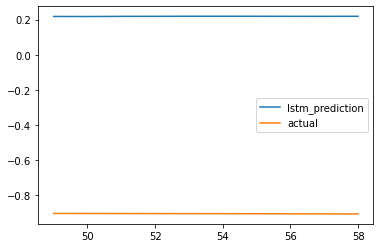

MSE lstm: 1.2496819730318263
MAE lstm: 1.1178806922775164


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [50]:
x_data, y_data = lstm(9,12)
model = load_lstm()
lstm_val_pred = model.predict(x_data)
print(lstm_val_pred)
evaluate_lstm(lstm_val_pred,y_data)